# Peak Progression Analysis with Coastal Transects

Analyze the seasonal progression of biogeochemical peaks using transects perpendicular to the coast.

**Objectives:**
- Create transect lines perpendicular to the coast
- Extract and average data along each transect
- Model the seasonal progression of peaks along the coast

## 1. Setup and Load Data

In [1]:
# Import libraries
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from shapely.geometry import LineString, Point
from shapely.ops import substring

%matplotlib inline

In [2]:
# Set up paths
data_dir = Path('../data/raw')
copernicus_dir = data_dir / 'copernicus'
shapefiles_dir = data_dir / 'shapefiles'
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load biogeochemical data
nc_file = copernicus_dir / 'copernicus_bgc_2005-01-01_2024-12-31.nc'
print(f"Loading: {nc_file}")
ds = xr.open_dataset(nc_file)
print(f"Loaded {len(ds.time)} time steps from {ds.time.min().values} to {ds.time.max().values}")

Loading: ../data/raw/copernicus/copernicus_bgc_2005-01-01_2024-12-31.nc
Loaded 7305 time steps from 2005-01-01T00:00:00.000000000 to 2024-12-31T00:00:00.000000000


In [4]:
# Load California Current shapefile
shapefile_path = shapefiles_dir / 'california_current_lme.shp'
california_current = gpd.read_file(shapefile_path)
print(f"Loaded California Current shapefile: {len(california_current)} feature(s)")

Loaded California Current shapefile: 1 feature(s)


In [5]:
# Apply California Current mask
print("Creating spatial mask for California Current polygon...")

cc_polygon = california_current.geometry.iloc[0]
lats = ds.latitude.values
lons = ds.longitude.values
mask = np.zeros((len(lats), len(lons)), dtype=bool)

for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        point = Point(lon, lat)
        mask[i, j] = cc_polygon.contains(point)

print(f"Mask created: {mask.sum()} / {mask.size} grid points inside polygon ({100*mask.sum()/mask.size:.1f}%)")

# Apply mask
ds_masked = ds.copy(deep=True)
for var in ds_masked.data_vars:
    mask_3d = np.broadcast_to(mask, ds_masked[var].shape)
    ds_masked[var].values = np.where(mask_3d, ds_masked[var].values, np.nan)

ds = ds_masked
print("Mask applied")

Creating spatial mask for California Current polygon...


Mask created: 31072 / 87360 grid points inside polygon (35.6%)


Mask applied


## 2. Create Latitude Bins and Compute Climatology

In [6]:
# Define latitude bins
lat_bin_size = 0.5  # degrees
min_offshore_extent_km = 500  # minimum offshore extent

# Get bounds
minx, miny, maxx, maxy = california_current.total_bounds

# Create latitude bin edges
lat_bins = np.arange(miny, maxy + lat_bin_size, lat_bin_size)
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

print(f"Created {len(lat_centers)} latitude bins")
print(f"Bin size: {lat_bin_size}°")
print(f"Latitude range: {lat_bins.min():.2f}° to {lat_bins.max():.2f}°N")

Created 53 latitude bins
Bin size: 0.5°
Latitude range: 21.84° to 48.34°N


In [7]:
# For each bin, check offshore extent and compute climatology
import pandas as pd

bin_data = []

for i, lat_center in enumerate(lat_centers):
    lat_min = lat_bins[i]
    lat_max = lat_bins[i + 1]
    
    # Select data in this latitude band
    lat_mask = (ds.latitude >= lat_min) & (ds.latitude < lat_max)
    
    # Get the data for this latitude band
    zooc_band = ds['zooc'].sel(latitude=lat_mask)
    npp_band = ds['npp'].sel(latitude=lat_mask)
    
    # Check offshore extent (longitude range with valid data)
    # Get a sample time to check spatial extent
    sample_data = zooc_band.isel(time=0)
    
    # Find longitude range with non-NaN data
    has_data = ~np.isnan(sample_data).all(dim='latitude')
    
    if not has_data.any():
        continue
    
    lons_with_data = ds.longitude.values[has_data.values]
    
    if len(lons_with_data) == 0:
        continue
    
    lon_min = lons_with_data.min()
    lon_max = lons_with_data.max()
    
    # Calculate offshore extent in km
    offshore_extent_deg = lon_max - lon_min
    offshore_extent_km = offshore_extent_deg * 111.0 * np.cos(np.radians(lat_center))
    
    # Only include bins with sufficient offshore extent
    if offshore_extent_km < min_offshore_extent_km:
        continue
    
    # Compute climatological mean (average over time and space)
    zooc_clim = zooc_band.mean(dim=['time', 'latitude', 'longitude'], skipna=True).values
    npp_clim = npp_band.mean(dim=['time', 'latitude', 'longitude'], skipna=True).values
    
    # Also compute climatology by day of year
    zooc_by_doy = zooc_band.groupby('time.dayofyear').mean(dim=['time', 'latitude', 'longitude'], skipna=True)
    npp_by_doy = npp_band.groupby('time.dayofyear').mean(dim=['time', 'latitude', 'longitude'], skipna=True)
    
    bin_data.append({
        'lat_center': lat_center,
        'lat_min': lat_min,
        'lat_max': lat_max,
        'lon_min': lon_min,
        'lon_max': lon_max,
        'offshore_extent_km': offshore_extent_km,
        'zooc_mean': float(zooc_clim),
        'npp_mean': float(npp_clim),
        'zooc_by_doy': zooc_by_doy.values,
        'npp_by_doy': npp_by_doy.values
    })

# Create DataFrame
bins_df = pd.DataFrame(bin_data)
print(f"\nKept {len(bins_df)} latitude bins with ≥{min_offshore_extent_km} km offshore extent")
print(f"Latitude range: {bins_df['lat_center'].min():.2f}° to {bins_df['lat_center'].max():.2f}°N")
print(f"Offshore extent range: {bins_df['offshore_extent_km'].min():.0f} - {bins_df['offshore_extent_km'].max():.0f} km")
bins_df[['lat_center', 'offshore_extent_km', 'zooc_mean', 'npp_mean']].head(10)


Kept 45 latitude bins with ≥500 km offshore extent
Latitude range: 22.09° to 44.09°N
Offshore extent range: 551 - 1088 km


,lat_center,offshore_extent_km,zooc_mean,npp_mean
0,22.085861,908.552608,0.654626,414.946234
1,22.585861,956.544227,0.693355,408.467157
2,23.085861,1012.599828,0.756717,424.635413
3,23.585861,1051.181559,0.865437,465.545532
4,24.085861,1004.912882,0.939324,498.141084
5,24.585861,950.486165,0.864145,445.849701
6,25.085861,971.787391,0.934678,464.268065
7,25.585861,1026.181238,1.027291,494.601459
8,26.085861,1055.085616,1.129917,525.779331
9,26.585861,1050.536913,1.126926,551.617919


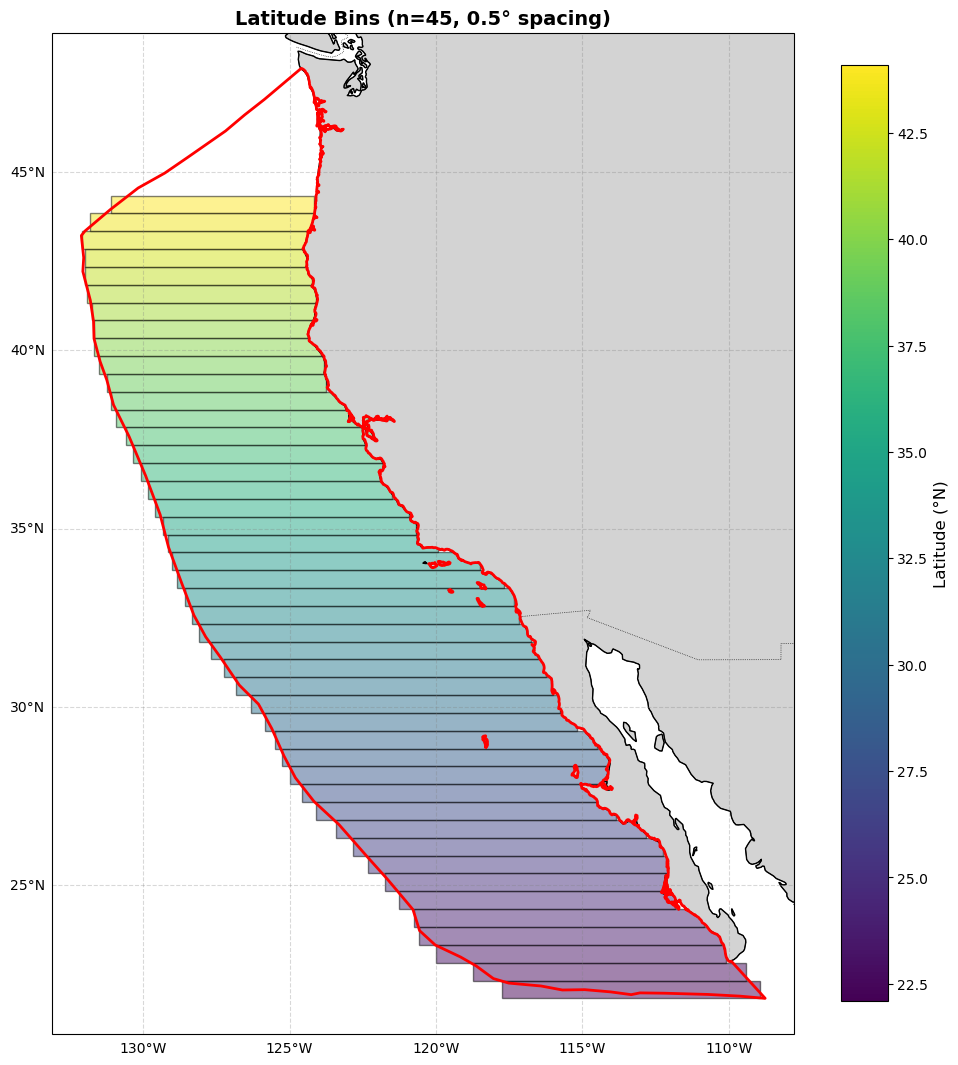

In [8]:
# Create map showing latitude bins
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot each latitude bin as a colored rectangle
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

norm = Normalize(vmin=bins_df['lat_center'].min(), vmax=bins_df['lat_center'].max())
cmap = viridis

for idx, row in bins_df.iterrows():
    # Create rectangle for this bin
    rect = mpatches.Rectangle(
        (row['lon_min'], row['lat_min']),
        row['lon_max'] - row['lon_min'],
        row['lat_max'] - row['lat_min'],
        linewidth=1,
        edgecolor='black',
        facecolor=cmap(norm(row['lat_center'])),
        alpha=0.5,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

# Plot California Current boundary
california_current.plot(ax=ax, facecolor='none', 
                       edgecolor='red', linewidth=2, label='CA Current', zorder=3)

# Add geographic features
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.3, color='gray')
gl.top_labels = False
gl.right_labels = False

# Set extent
ax.set_extent([minx-1, maxx+1, miny-1, maxy+1], crs=ccrs.PlateCarree())

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, shrink=0.8)
cbar.set_label('Latitude (°N)', fontsize=12)

ax.set_title(f'Latitude Bins (n={len(bins_df)}, {lat_bin_size}° spacing)', 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'latitude_bins_map.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Visualize Climatological Averages

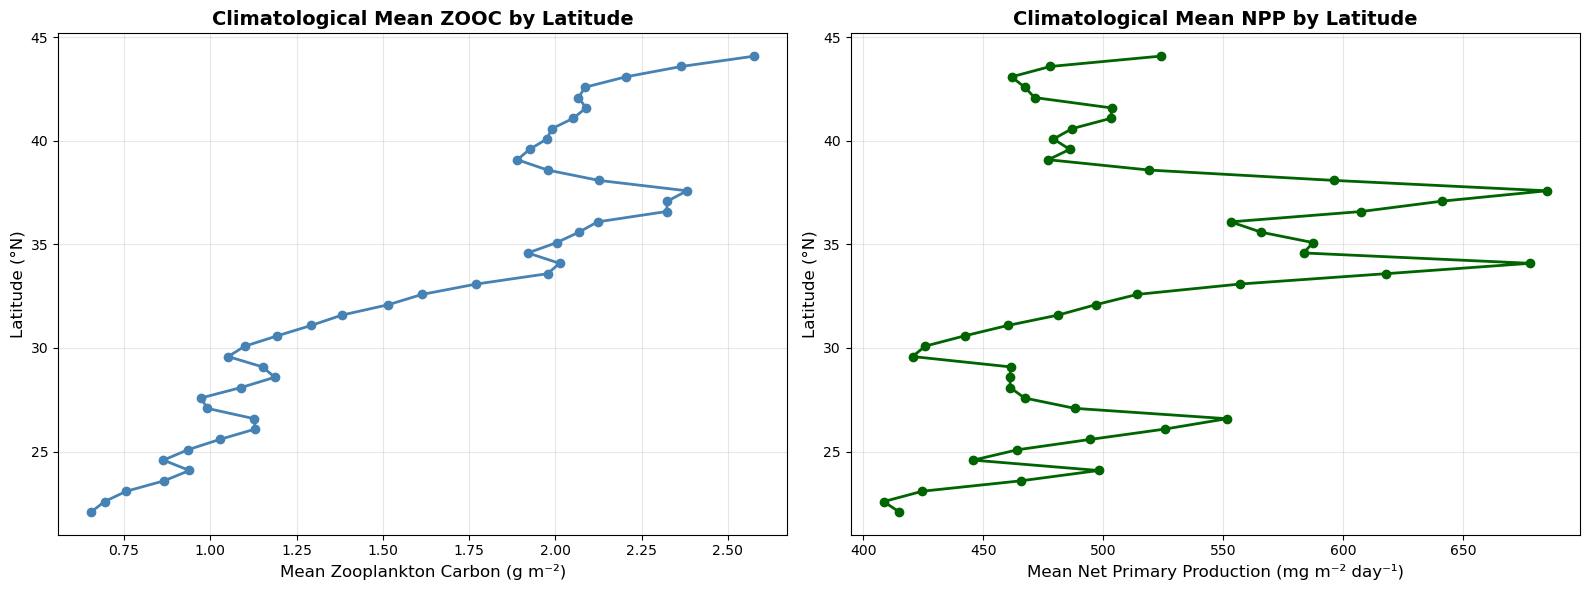

In [9]:
# Plot climatological mean by latitude
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ZOOC
axes[0].plot(bins_df['zooc_mean'], bins_df['lat_center'], 
            marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0].set_xlabel('Mean Zooplankton Carbon (g m⁻²)', fontsize=12)
axes[0].set_ylabel('Latitude (°N)', fontsize=12)
axes[0].set_title('Climatological Mean ZOOC by Latitude', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# NPP
axes[1].plot(bins_df['npp_mean'], bins_df['lat_center'], 
            marker='o', linewidth=2, markersize=6, color='darkgreen')
axes[1].set_xlabel('Mean Net Primary Production (mg m⁻² day⁻¹)', fontsize=12)
axes[1].set_ylabel('Latitude (°N)', fontsize=12)
axes[1].set_title('Climatological Mean NPP by Latitude', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'climatology_by_latitude.png', dpi=300, bbox_inches='tight')
plt.show()

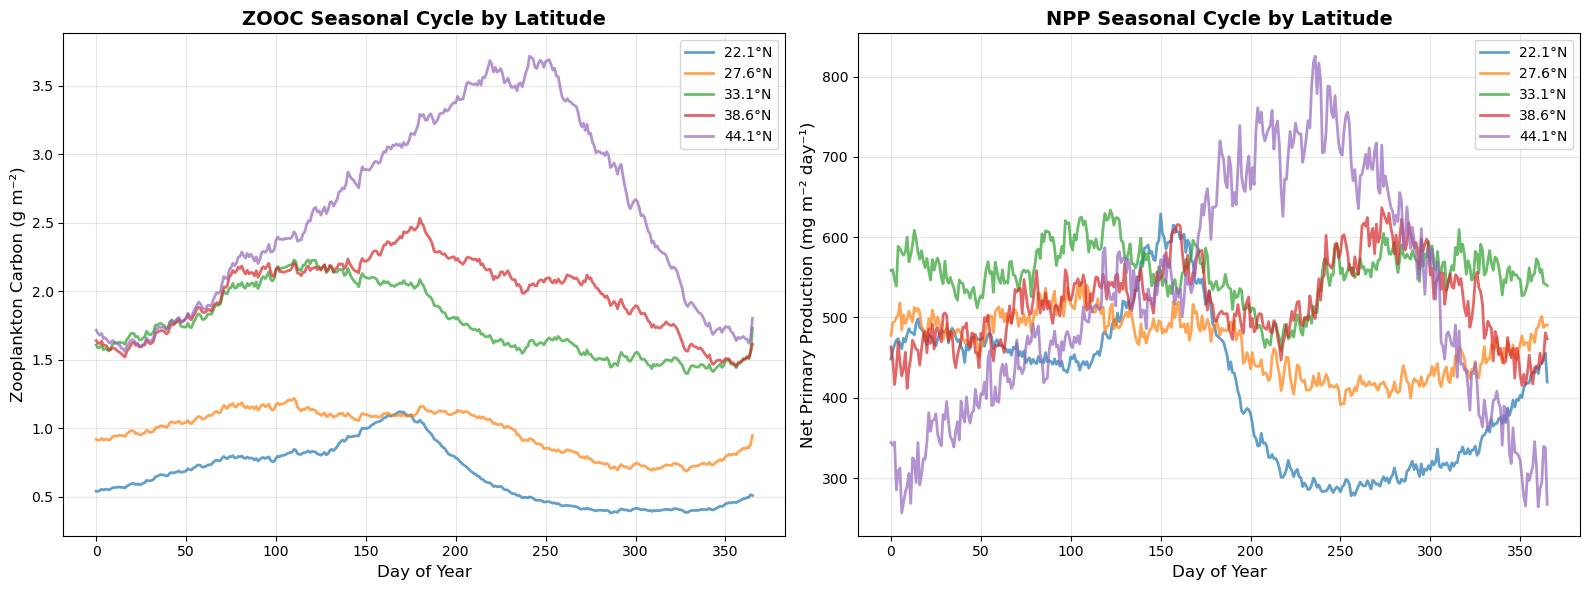

In [10]:
# Plot seasonal cycle at different latitudes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Select a few representative latitudes
n_show = 5
indices = np.linspace(0, len(bins_df)-1, n_show, dtype=int)

# ZOOC seasonal cycle
for idx in indices:
    row = bins_df.iloc[idx]
    axes[0].plot(row['zooc_by_doy'], 
                label=f"{row['lat_center']:.1f}°N",
                linewidth=2, alpha=0.7)

axes[0].set_xlabel('Day of Year', fontsize=12)
axes[0].set_ylabel('Zooplankton Carbon (g m⁻²)', fontsize=12)
axes[0].set_title('ZOOC Seasonal Cycle by Latitude', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# NPP seasonal cycle
for idx in indices:
    row = bins_df.iloc[idx]
    axes[1].plot(row['npp_by_doy'], 
                label=f"{row['lat_center']:.1f}°N",
                linewidth=2, alpha=0.7)

axes[1].set_xlabel('Day of Year', fontsize=12)
axes[1].set_ylabel('Net Primary Production (mg m⁻² day⁻¹)', fontsize=12)
axes[1].set_title('NPP Seasonal Cycle by Latitude', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'seasonal_cycle_by_latitude.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Find Peak Day of Year for Each Band

In [11]:
# For each latitude band, find the day of year when zooc peaks
peak_info = []

for idx, row in bins_df.iterrows():
    # Find peak day for ZOOC
    zooc_peak_doy = np.argmax(row['zooc_by_doy']) + 1  # +1 because dayofyear starts at 1
    zooc_peak_val = np.max(row['zooc_by_doy'])
    
    # Find peak day for NPP
    npp_peak_doy = np.argmax(row['npp_by_doy']) + 1
    npp_peak_val = np.max(row['npp_by_doy'])
    
    peak_info.append({
        'lat_center': row['lat_center'],
        'zooc_peak_doy': zooc_peak_doy,
        'zooc_peak_val': zooc_peak_val,
        'npp_peak_doy': npp_peak_doy,
        'npp_peak_val': npp_peak_val
    })

# Create DataFrame
peaks_df = pd.DataFrame(peak_info)
print(f"Found peak day of year for {len(peaks_df)} latitude bands")
print(f"\nZOOC peak timing range: day {peaks_df['zooc_peak_doy'].min()} to {peaks_df['zooc_peak_doy'].max()}")
print(f"NPP peak timing range: day {peaks_df['npp_peak_doy'].min()} to {peaks_df['npp_peak_doy'].max()}")
peaks_df.head(10)

Found peak day of year for 45 latitude bands

ZOOC peak timing range: day 82 to 242
NPP peak timing range: day 6 to 305


,lat_center,zooc_peak_doy,zooc_peak_val,npp_peak_doy,npp_peak_val
0,22.085861,170,1.121783,151,628.854112
1,22.585861,170,1.132488,160,619.261763
2,23.085861,163,1.220766,152,638.421475
3,23.585861,163,1.531691,158,762.966531
4,24.085861,168,1.716387,174,782.487582
5,24.585861,176,1.349537,166,571.081640
6,25.085861,157,1.405488,164,607.326520
7,25.585861,155,1.624630,166,699.078347
8,26.085861,172,1.937245,151,785.545135
9,26.585861,183,1.768023,169,769.297074


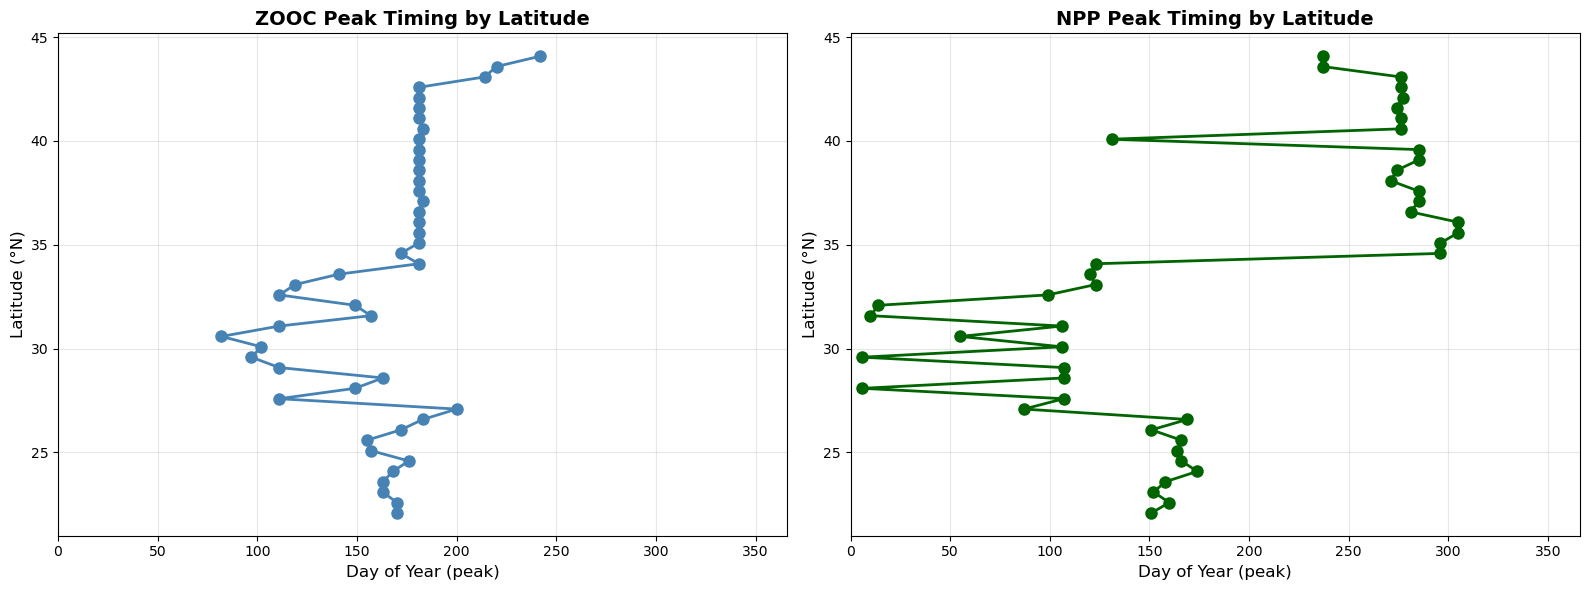

In [12]:
# Plot peak day of year vs latitude
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ZOOC peak timing
axes[0].plot(peaks_df['zooc_peak_doy'], peaks_df['lat_center'], 
            marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Day of Year (peak)', fontsize=12)
axes[0].set_ylabel('Latitude (°N)', fontsize=12)
axes[0].set_title('ZOOC Peak Timing by Latitude', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 366)

# NPP peak timing
axes[1].plot(peaks_df['npp_peak_doy'], peaks_df['lat_center'], 
            marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('Day of Year (peak)', fontsize=12)
axes[1].set_ylabel('Latitude (°N)', fontsize=12)
axes[1].set_title('NPP Peak Timing by Latitude', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 366)

plt.tight_layout()
plt.savefig(figures_dir / 'peak_timing_by_latitude.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Calculate Gonatidae brooding date (9 months before zooc peak)
# 9 months ≈ 273 days
offset_days = 273

peaks_df['gonatidae_brooding_doy'] = (peaks_df['zooc_peak_doy'] - offset_days) % 365
# Ensure it's at least 1 (dayofyear starts at 1, not 0)
peaks_df['gonatidae_brooding_doy'] = peaks_df['gonatidae_brooding_doy'].apply(
    lambda x: x if x > 0 else x + 365
)

print(f"Gonatidae brooding date (9 months before ZOOC peak)")
print(f"Range: day {peaks_df['gonatidae_brooding_doy'].min():.0f} to {peaks_df['gonatidae_brooding_doy'].max():.0f}")
peaks_df[['lat_center', 'zooc_peak_doy', 'gonatidae_brooding_doy']].head(10)

Gonatidae brooding date (9 months before ZOOC peak)
Range: day 174 to 334


,lat_center,zooc_peak_doy,gonatidae_brooding_doy
0,22.085861,170,262
1,22.585861,170,262
2,23.085861,163,255
3,23.585861,163,255
4,24.085861,168,260
5,24.585861,176,268
6,25.085861,157,249
7,25.585861,155,247
8,26.085861,172,264
9,26.585861,183,275


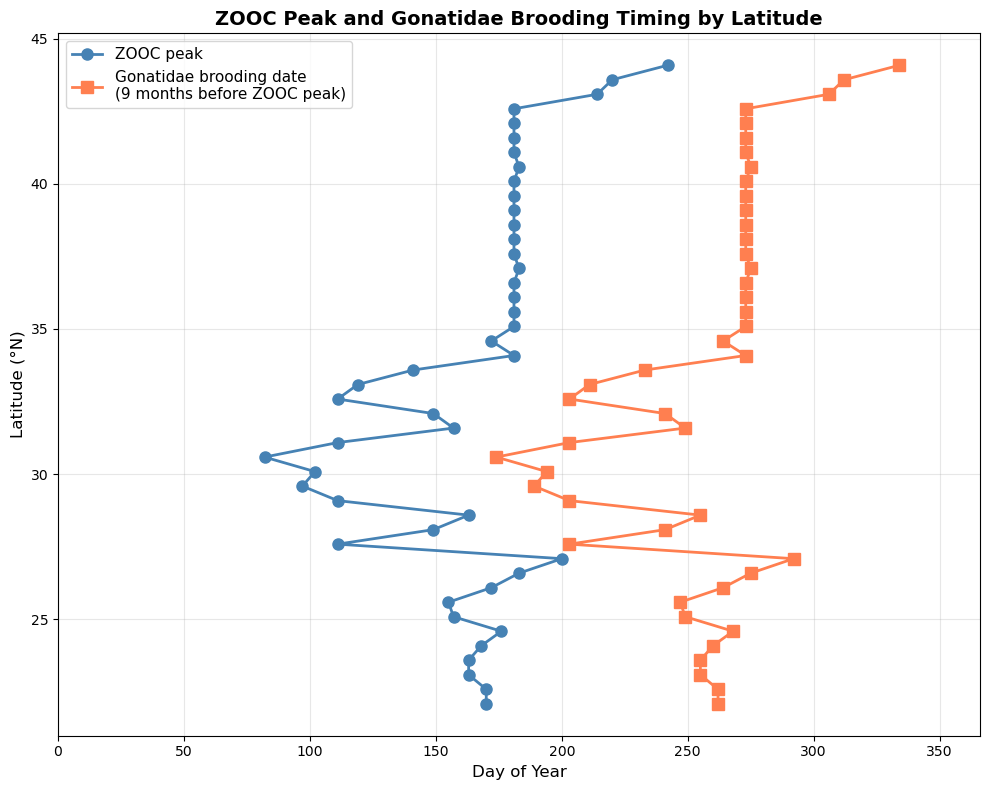

In [14]:
# Plot Gonatidae brooding date and ZOOC peak timing together
fig, ax = plt.subplots(figsize=(10, 8))

# ZOOC peak timing
ax.plot(peaks_df['zooc_peak_doy'], peaks_df['lat_center'], 
        marker='o', linewidth=2, markersize=8, color='steelblue', 
        label='ZOOC peak')

# Gonatidae brooding date
ax.plot(peaks_df['gonatidae_brooding_doy'], peaks_df['lat_center'], 
        marker='s', linewidth=2, markersize=8, color='coral', 
        label='Gonatidae brooding date\n(9 months before ZOOC peak)')

ax.set_xlabel('Day of Year', fontsize=12)
ax.set_ylabel('Latitude (°N)', fontsize=12)
ax.set_title('ZOOC Peak and Gonatidae Brooding Timing by Latitude', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 366)

plt.tight_layout()
plt.savefig(figures_dir / 'gonatidae_brooding_timing.png', dpi=300, bbox_inches='tight')
plt.show()